In [63]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


In [64]:
data = pd.read_csv("all_daily_max_temp.csv")  # Replace with your file name
features = ['elevation', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'dewpoint_c', 'feel_c']
target = 'temp_c'
data=data.drop(columns=['Unnamed: 0','is_hot_day'])
data

,elevation,relh,drct,sknt,alti,vsby,temp_c,dewpoint_c,feel_c
0,74,41.42,200.0,4.0,30.060,6.21,25.0,11.0,25.000000
1,74,33.85,230.0,11.0,30.000,1.86,25.0,8.0,24.438889
2,74,53.03,280.0,4.0,30.030,6.21,22.0,12.0,22.000000
3,74,59.97,280.0,5.0,30.090,6.21,20.0,12.0,20.000000
4,74,49.37,40.0,11.0,30.090,6.21,21.0,10.0,21.000000
...,...,...,...,...,...,...,...,...,...
5402,74,41.19,330.0,8.0,29.925,6.21,29.0,14.5,28.719444
5403,74,42.52,10.0,7.0,29.880,6.21,29.0,15.0,28.844444
5404,74,39.58,30.0,9.0,29.970,6.21,28.0,13.0,27.638889
5405,74,34.69,40.0,18.0,30.060,6.21,28.0,11.0,27.333333


In [65]:
import numpy as np

# Alternative function to create sequences using sliding windows
def create_sequences_alternative(data, target_col, window_size, prediction_horizon):
    X, y = [], []
    
    # Iterate over the dataset using a sliding window
    for i in range(len(data) - window_size - prediction_horizon + 1):
        # Extract the feature values for the past 'window_size' time steps
        X_seq = data.iloc[i:i + window_size][features].values
        
        # Extract the target values for the next 'prediction_horizon' time steps
        y_seq = data.iloc[i + window_size:i + window_size + prediction_horizon][target_col].values
        
        # Append the sequences to the list
        X.append(X_seq)
        y.append(y_seq)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Parameters
window_size = 3  # Number of timesteps to look at for each sequence
prediction_horizon = 1  # Predict the next 3 days

# Create input-output pairs using the alternative method
X,y= create_sequences_alternative(data, target, window_size, prediction_horizon)

# Display the shapes of the data to check
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"X train ,test shape: {X_train.shape, X_test.shape}")
print(f"y train ,test shape: {y_train.shape, y_test.shape}")


X shape: (5404, 3, 8)
y shape: (5404, 1)
X train ,test shape: ((4323, 3, 8), (1081, 3, 8))
y train ,test shape: ((4323, 1), (1081, 1))


Train Loss: 6.5804, Train MAE: 1.8851
Test Loss: 5.6151, Test MAE: 1.7974
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
R²: 0.8769


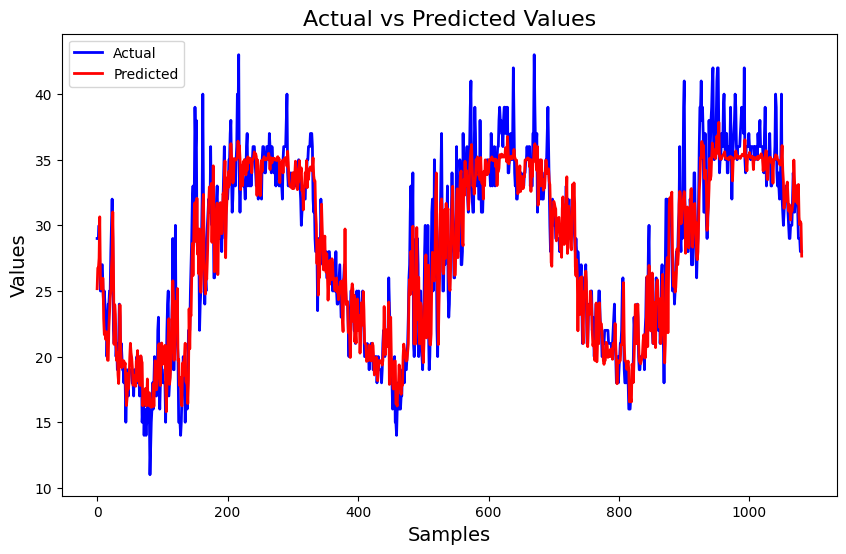

In [66]:
# Load pre-trained model
model = load_model('1 day prediction woa-cnn-att-lstm.keras')  # Replace with the correct file path

# Evaluate the model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Predict values for the test set and compute R²
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted', color='red', linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [67]:
# Function to iteratively predict future temperatures
def iterative_prediction(model, X_input, features, window_size, iterations=3):
    predictions = []
    current_sequence = X_input.copy()  # Start with the given sequence
    for _ in range(iterations):
        # Predict the next temperature
        next_temp = model.predict(current_sequence)[0][0]
        predictions.append(next_temp)
        
        # Update the sequence
        next_sequence = current_sequence[0, 1:, :].tolist()  # Remove the oldest step
        # Append a new step with predicted value and zeros for other features
        new_step = [0] * len(features)  # Initialize new step
        new_step[0] = next_temp  # Assuming temperature is the first feature
        next_sequence.append(new_step)  # Add new step to the sequence
        current_sequence = np.array([next_sequence])  # Update sequence
    
    return predictions

In [68]:
# Predict 3 future temperatures
X_initial = X_test[-1].reshape(1, window_size, len(features))
future_predictions = iterative_prediction(
    model, X_initial, features, window_size, iterations=3
)
print(f"Future Predicted Temperatures: {future_predictions}")

# Check for heat wave
heat_wave_threshold = 36.0
is_heat_wave = all(temp >= heat_wave_threshold for temp in future_predictions)
if is_heat_wave:
    print("Heat wave detected!")
else:
    print("No heat wave detected.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Future Predicted Temperatures: [27.657907, 30.012594, 28.866482]
No heat wave detected.


In [69]:
import pandas as pd

# Initialize the features and target
features = ['elevation', 'relh', 'drct', 'sknt', 'alti', 'vsby', 'dewpoint_c', 'feel_c']
target = 'temp_c'

# Check the number of rows in your data
n_rows = len(data)

# Generate the date range for the dataset
start_date = "2010-01-01"
end_date = "2024-10-22"
dates = pd.date_range(start=start_date, periods=n_rows, freq="D")

# Add the date column to the original DataFrame
data['date'] = dates

# Ensure the data length is divisible by 3 for non-overlapping groups
trimmed_length = (n_rows // 3) * 3
data_trimmed = data.iloc[:trimmed_length]

# Reshape the data into non-overlapping 3-day groups
rows = []
for i in range(0, len(data_trimmed), 3):  # Step by 3 to create non-overlapping groups
    temp_3_days = data_trimmed.iloc[i:i + 3][target].values  # Extract temp_c for 3 consecutive rows
    date_range = data_trimmed.iloc[i:i + 3]['date'].values  # Extract the corresponding dates
    heat_wave = int((temp_3_days >= 36).all())  # Label as 1 if all three days >= 36°C, else 0
    rows.append({
        "start_date": date_range[0],  # Start date of the 3-day window
        "end_date": date_range[-1],  # End date of the 3-day window
        **{f"temp_c_day_{j+1}": temp_3_days[j] for j in range(3)},  # Add temps
        "heat_wave": heat_wave  # Add label
    })

# Convert rows to a DataFrame
heat_wave_df = pd.DataFrame(rows)

# Display the first few rows of the new DataFrame
heat_wave_df


,start_date,end_date,temp_c_day_1,temp_c_day_2,temp_c_day_3,heat_wave
0,2010-01-01,2010-01-03,25.0,25.0,22.0,0
1,2010-01-04,2010-01-06,20.0,21.0,22.0,0
2,2010-01-07,2010-01-09,23.0,24.0,27.0,0
3,2010-01-10,2010-01-12,28.0,22.0,19.0,0
4,2010-01-13,2010-01-15,20.0,21.0,22.0,0
...,...,...,...,...,...,...
1797,2024-10-05,2024-10-07,30.0,32.0,34.0,0
1798,2024-10-08,2024-10-10,33.0,31.0,32.0,0
1799,2024-10-11,2024-10-13,32.0,33.0,33.0,0
1800,2024-10-14,2024-10-16,31.0,29.0,29.0,0


In [70]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd

# Features and target
X = heat_wave_df[['temp_c_day_1', 'temp_c_day_2', 'temp_c_day_3']]
y = heat_wave_df['heat_wave']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Train a Logistic Regression model (simpler, avoids overfitting)
clf = LogisticRegression(random_state=42, max_iter=200)
clf.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(clf, X_balanced, y_balanced, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f}")

# Predict and evaluate on test set
y_pred = clf.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Merge with Predicted Temperatures
# Assuming `future_predictions` contains 3 predicted temperatures
predicted_heat_wave = clf.predict([future_predictions])[0]

print(f"Future Temperatures: {future_predictions}")
print(f"Predicted Heat Wave (1=Yes, 0=No): {predicted_heat_wave}")


Cross-Validation Accuracy: 0.97
Accuracy on Test Set: 0.9718100890207715
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       337
           1       0.95      1.00      0.97       337

    accuracy                           0.97       674
   macro avg       0.97      0.97      0.97       674
weighted avg       0.97      0.97      0.97       674

Confusion Matrix:
 [[318  19]
 [  0 337]]
Future Temperatures: [27.657907, 30.012594, 28.866482]
Predicted Heat Wave (1=Yes, 0=No): 0


c:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Accuracy on Test Set: 0.9718100890207715
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       337
           1       0.95      1.00      0.97       337

    accuracy                           0.97       674
   macro avg       0.97      0.97      0.97       674
weighted avg       0.97      0.97      0.97       674

Confusion Matrix:
 [[318  19]
 [  0 337]]


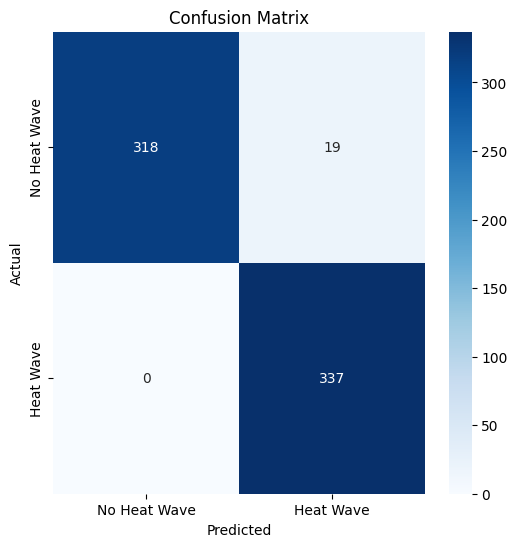

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict and evaluate on test set
y_pred = clf.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heat Wave', 'Heat Wave'], yticklabels=['No Heat Wave', 'Heat Wave'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
